## Intel Image Classification using Neural Networks
by Allen Wang

Create an image classifier of an image dataset of 6 different natural scenarios using different architectures of neural networks.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
%matplotlib inline
import os

In [2]:
batch_size = 32
img_height = 150
img_width = 150

Building the image dataset and splitting training data and validation data and their respective labels

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = 'Images\seg_train\seg_train',
    subset = 'training',
    validation_split = 0.2,
    seed=123,
    image_size=(img_height, img_width),
    batch_size = batch_size)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = 'Images\seg_train\seg_train',
  seed=123,
    validation_split = 0.2,
    subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = 'Images\seg_test\seg_test',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


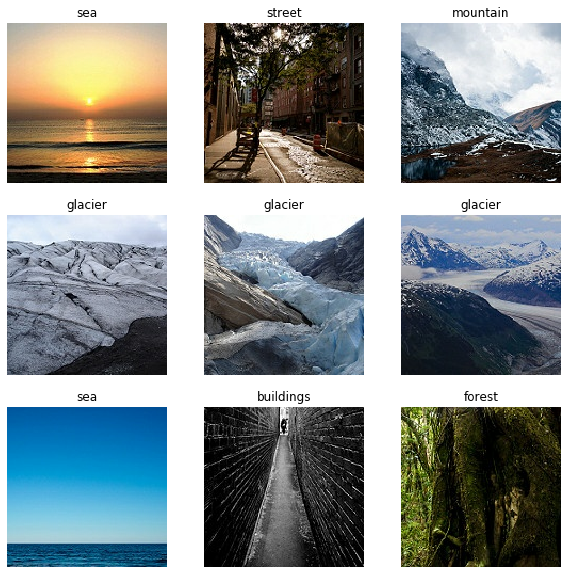

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [9]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standard Convolutional Neural Network

In [12]:
num_classes = 6

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Dropout(.3),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.Dropout(.2), 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Dropout(.15), 
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [13]:
from keras.layers.normalization import BatchNormalization
model.add(BatchNormalization())
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [14]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
) 

Epoch 1/10
351/351 [==============================] - 268s 761ms/step - loss: 1.1498 - accuracy: 0.5972 - val_loss: 1.3456 - val_accuracy: 0.3133
Epoch 2/10
351/351 [==============================] - 268s 765ms/step - loss: 0.7347 - accuracy: 0.7757 - val_loss: 0.8390 - val_accuracy: 0.7363
Epoch 3/10
351/351 [==============================] - 255s 726ms/step - loss: 0.5675 - accuracy: 0.8294 - val_loss: 0.7729 - val_accuracy: 0.7541
Epoch 4/10
351/351 [==============================] - 268s 765ms/step - loss: 0.4463 - accuracy: 0.8743 - val_loss: 0.6918 - val_accuracy: 0.7698
Epoch 5/10
351/351 [==============================] - 266s 759ms/step - loss: 0.3196 - accuracy: 0.9199 - val_loss: 0.5890 - val_accuracy: 0.8104
Epoch 6/10
351/351 [==============================] - 257s 733ms/step - loss: 0.2276 - accuracy: 0.9537 - val_loss: 0.6580 - val_accuracy: 0.7769
Epoch 7/10
351/351 [==============================] - 247s 704ms/step - loss: 0.1631 - accuracy: 0.9736 - val_loss: 0.6664 -

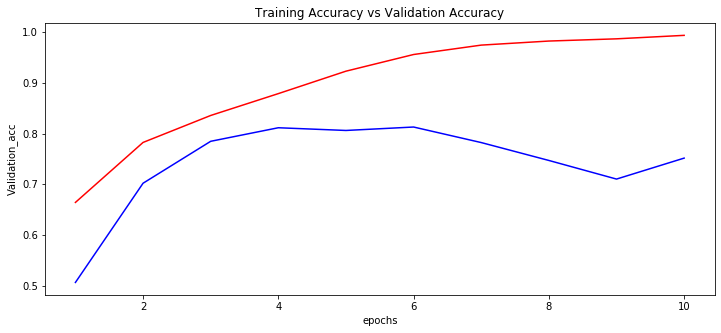

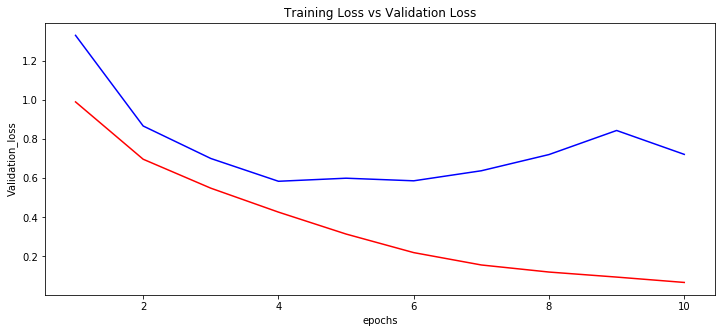

In [18]:
results = pd.DataFrame({'epochs':list(range(1,11)),'Training_acc':model.history.history['accuracy'],'Validation_acc':model.history.history['val_accuracy'],
                      'Training_loss':model.history.history['loss'],'Validation_loss':model.history.history['val_loss']})

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_acc', data = results, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_acc', data = results, color='blue' )
plt.title('Training Accuracy vs Validation Accuracy')
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_loss', data = results, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_loss', data = results, color='blue' )
plt.title('Training Loss vs Validation Loss')
plt.show()

In [20]:
model.evaluate(test_ds)

94/94 [==============================] - 22s 225ms/step - loss: 0.7618 - accuracy: 0.7457


[0.7617859840393066, 0.7456666827201843]

The model starts to overfit heavily after the 3rd epoch. The high accuracy on the training data is heavily skewed and the validation loss increases too much after the 3rd epoch. Evaluating the model at the 3rd epoch shows that the model maxes out at 79.8% accuracy. 

In [39]:
layers_info = {}
for i in model.layers:
    layers_info[i.name] = i.get_config()

#here the layer_weights dictionary will map every layer_name to its corresponding weights
layer_weights = {}
for i in model.layers:
    layer_weights[i.name] = i.get_weights()

print(layers_info)

{'rescaling_1': {'name': 'rescaling_1', 'trainable': True, 'dtype': 'float32', 'scale': 0.00392156862745098, 'offset': 0.0}, 'conv2d': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'dropout': {'name': 'dropout', 'trainable': True, 'dtype': 'float32', 'rate': 0.3, 'noise_shape': None, 'seed': None}, 'max_pooling2d': {'name': 'max_pooling2d', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}, 'conv2d_1': {'name': 'conv2d_1', 'trainable': Tru

ResNET50 Architecture:

In [44]:
import glob
import numpy as np
import pandas as pd 

In [45]:
glob.glob('Images/seg_train/seg_train/*')

['Images/seg_train/seg_train\\buildings',
 'Images/seg_train/seg_train\\forest',
 'Images/seg_train/seg_train\\glacier',
 'Images/seg_train/seg_train\\mountain',
 'Images/seg_train/seg_train\\sea',
 'Images/seg_train/seg_train\\street']

In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [47]:
def prepare_dataset(path,label):
    x_train=[]
    y_train=[]
    all_images_path=glob.glob(path+'/*.jpg')
    for img_path in all_images_path :
            img=load_img(img_path, target_size=(150,150))
            img=img_to_array(img)
            img=img/255.0
            x_train.append(img)
            y_train.append(label)
    return np.array(x_train),np.array(y_train)

In [48]:
paths=glob.glob('Images/seg_train/seg_train/*')
l=len('Images/seg_train/seg_train/')
labels=[]
for path in paths:
    labels.append(path[l:])
    print(labels)

['buildings']
['buildings', 'forest']
['buildings', 'forest', 'glacier']
['buildings', 'forest', 'glacier', 'mountain']
['buildings', 'forest', 'glacier', 'mountain', 'sea']
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [49]:
trainX_building, trainY_building  = prepare_dataset("Images/seg_train/seg_train/buildings/",0)
trainX_forest,trainY_forest  = prepare_dataset("Images/seg_train/seg_train/forest/",1)
trainX_glacier,trainY_glacier  = prepare_dataset("Images/seg_train/seg_train/glacier/",2)
trainX_mount,trainY_mount  = prepare_dataset("Images/seg_train/seg_train/mountain/",3)
trainX_sea,trainY_sea  = prepare_dataset("Images/seg_train/seg_train/sea/",4)
trainX_street,trainY_street  = prepare_dataset("Images/seg_train/seg_train/street/",5)

print('train building shape ', trainX_building.shape, trainY_building.shape) 
print('train forest', trainX_forest.shape ,trainY_forest.shape)
print('train glacier', trainX_glacier.shape,trainY_glacier.shape)
print('train mountain', trainX_mount.shape, trainY_mount.shape)
print('train sea',     trainX_sea.shape, trainY_sea.shape)
print('train street', trainX_street.shape ,trainY_street.shape)

train building shape  (2191, 150, 150, 3) (2191,)
train forest (2271, 150, 150, 3) (2271,)
train glacier (2404, 150, 150, 3) (2404,)
train mountain (2512, 150, 150, 3) (2512,)
train sea (2274, 150, 150, 3) (2274,)
train street (2382, 150, 150, 3) (2382,)


In [50]:
testX_building, testY_building  = prepare_dataset("Images/seg_test/seg_test/buildings/",0)
testX_forest,testY_forest  = prepare_dataset("Images/seg_test/seg_test/forest/",1)
testX_glacier,testY_glacier  = prepare_dataset("Images/seg_test/seg_test/glacier/",2)
testX_mount,testY_mount  = prepare_dataset("Images/seg_test/seg_test/mountain/",3)
testX_sea,testY_sea  = prepare_dataset("Images/seg_test/seg_test/sea/",4)
testX_street,testY_street  = prepare_dataset("Images/seg_test/seg_test/street/",5)

print('test building shape ', testX_building.shape, testY_building.shape) 
print('test forest', testX_forest.shape ,testY_forest.shape)
print('test glacier', testX_glacier.shape,testY_glacier.shape)
print('test mountain', testX_mount.shape, testY_mount.shape)
print('test sea',     testX_sea.shape, testY_sea.shape)
print('test street', testX_street.shape ,testY_street.shape)

test building shape  (437, 150, 150, 3) (437,)
test forest (474, 150, 150, 3) (474,)
test glacier (553, 150, 150, 3) (553,)
test mountain (525, 150, 150, 3) (525,)
test sea (510, 150, 150, 3) (510,)
test street (501, 150, 150, 3) (501,)


In [51]:
x_train=np.concatenate((trainX_building,trainX_forest,trainX_glacier,trainX_mount,trainX_sea,trainX_street),axis=0)
y_train=np.concatenate((trainY_building,trainY_forest,trainY_glacier,trainY_mount,trainY_sea,trainY_street),axis=0)

In [52]:
print(x_train.shape)
print(y_train.shape)

(14034, 150, 150, 3)
(14034,)


In [53]:
x_test=np.concatenate((testX_building,testX_forest,testX_glacier,testX_mount,testX_sea,testX_street),axis=0)
y_test=np.concatenate((testY_building,testY_forest,testY_glacier,testY_mount,testY_sea,testY_street),axis=0)

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)

In [55]:
print(x_test.shape)
print(y_test.shape)

(3000, 150, 150, 3)
(3000,)


In [56]:
print(x_val.shape)
print(y_val.shape)

(2807, 150, 150, 3)
(2807,)


Creating the ResNET50 Model:

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout

pretrained_model=ResNet50( input_shape=(150,150,3),
                                  include_top=False,
                                  weights='imagenet'
                                   )

for layer in pretrained_model.layers:
     layer.trainable = False

pretrained_model.summary()
       
last_layer = pretrained_model.get_layer('conv5_block3_out')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output = last_layer.output


x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)


#step5
#model_resnet = Model(pretrained_model.input, x) 
#step6

headModel = pretrained_model.output
headModel = MaxPooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(6, activation="softmax")(headModel)

modelresnet50 = Model(inputs=pretrained_model.input, outputs=headModel)

modelresnet50.compile(optimizer=RMSprop(lr = 0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
modelresnet50.fit(x_train,
                  y_train,
                  epochs=20,
                  validation_data=(x_val,y_val))

In [ ]:
results = pd.DataFrame({'epochs':list(range(1,21)),'Training_acc':modelresnet50.history.history['accuracy'],'Validation_acc':modelresnet50.history.history['val_accuracy'],
                      'Training_loss':modelresnet50.history.history['loss'],'Validation_loss':modelresnet50.history.history['val_loss']})

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_acc', data = results, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_acc', data = results, color='blue' )
plt.title('Training Accuracy vs Validation Accuracy')
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_loss', data = results, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_loss', data = results, color='blue' )
plt.title('Training Loss vs Validation Loss')
plt.show()

The neural network starts to max out at 70% accuracy after the 16th epoch which shows that the model lacks in performance despite not overfitting or underfitting with the training and validation data.

In [ ]:
modelresnet50.evaluate(x_test, y_test)

VGG16 Architecture:

In [3]:
from keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rescale = 1.0/255,  # Ar RGB colors are presented in 0-155 range (1 pixel = 8 bits, since each bit can be 1 or 0, 8 bits info 2^8 = 256 , 0-255 , total 256)
                            horizontal_flip = True,
                            vertical_flip = True,
                             zoom_range = 0.2,
                             shear_range = 0.2,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             validation_split =0.2,
                             fill_mode = 'nearest'
                             
                            ) 

datagen_val = ImageDataGenerator(rescale = 1.0/255,  # Ar RGB colors are presented in 0-155 range (1 pixel = 8 bits, since each bit can be 1 or 0, 8 bits info 2^8 = 256 , 0-255 , total 256)
                            horizontal_flip = True,
                            vertical_flip = True,
                             zoom_range = 0.2,
                             shear_range = 0.2,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             validation_split =0.2,
                             fill_mode = 'nearest'
                             
                            ) 

train_datagen = datagen_train.flow_from_directory("Images/seg_train/seg_train/",
                                                 batch_size = 32,
                                                 target_size = (150,150),
                                                  class_mode = 'categorical',
                                                  color_mode = 'rgb',
                                                  subset = 'training',
                                                  seed = 101
                                                 )


val_datagen = datagen_val.flow_from_directory("Images/seg_train/seg_train/",
                                                 batch_size = 32,
                                                 target_size = (150,150),
                                                  class_mode = 'categorical',
                                                  color_mode = 'rgb',
                                                  subset = 'validation',
                                                  seed = 101
                                                 )

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [4]:
datagen_test = ImageDataGenerator(rescale = 1.0/255 )

test_datagen = datagen_test.flow_from_directory("Images/seg_test/seg_test/",
                                             batch_size = 32,
                                             target_size = (150,150),
                                             class_mode = 'categorical',
                                             color_mode ='rgb',
                                             seed = 110
                                             )

Found 3000 images belonging to 6 classes.


In [5]:
from keras.applications import VGG16
vgg16 = VGG16(include_top = False,input_shape=(150,150,3),
                  weights='imagenet',
                  classes = 6)

In [6]:
from  keras.callbacks import EarlyStopping, ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor = 'val_accuracy',
                       patience = 1,
                       factor = 0.25,
                        min_lr = 0.000003,
                        verbose =1
                       )

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience=3)

In [20]:
def build_model(base_modelx):
    
    for layer in base_modelx.layers:
        layer.trainable = False
    
    model = Sequential(base_modelx)
    model.add(Flatten())
    model.add(Dense(1024,activation ='relu'))
    model.add(Dense(512,activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dropout(0.15))
    model.add(Dense(6,activation='softmax'))
    
    print(model.summary())
    
    model.compile(loss = 'categorical_crossentropy',optimizer = 'adam' ,metrics =['accuracy'])
    
    return model

In [21]:
from keras import Sequential
modelvgg16 = build_model(vgg16)

modelvgg16.fit(train_datagen,
          epochs = 20,
          validation_data = val_datagen,
          verbose =1,
          callbacks =[lrr,early_stopping]
         )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

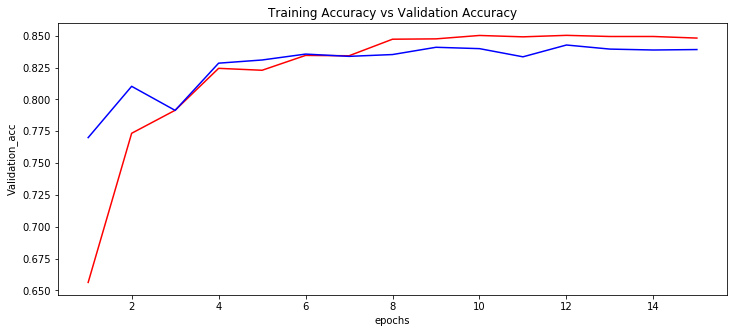

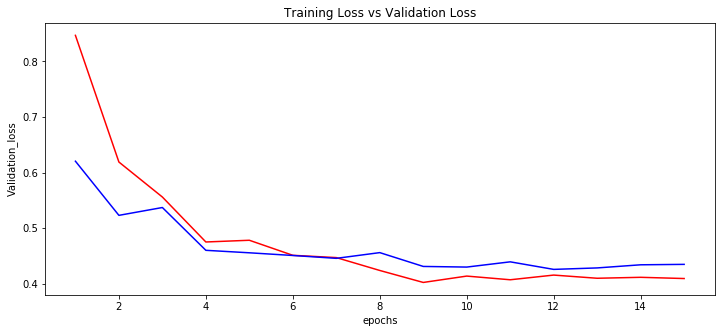

In [22]:
results = pd.DataFrame({'epochs':list(range(1,16)),'Training_acc':modelvgg16.history.history['accuracy'],'Validation_acc':modelvgg16.history.history['val_accuracy'],
                      'Training_loss':modelvgg16.history.history['loss'],'Validation_loss':modelvgg16.history.history['val_loss']})

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_acc', data = results, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_acc', data = results, color='blue' )
plt.title('Training Accuracy vs Validation Accuracy')
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(x = 'epochs', y ='Training_loss', data = results, color='r' )
sns.lineplot(x = 'epochs', y ='Validation_loss', data = results, color='blue' )
plt.title('Training Loss vs Validation Loss')
plt.show()

The model shows a stable plateau and a balance of accuracy, loss, validation accuracy, and validation loss while maintaining a high accuracy of 85%. The early stopping stopped the training at the 16th epoch because that is when the validation accuracy/loss and training accuracy/loss start to smooth out and drops no further. 

In [29]:
modelvgg16.evaluate(test_datagen)

94/94 [==============================] - 164s 2s/step - loss: 0.3810 - accuracy: 0.8530


[0.3809618651866913, 0.8529999852180481]

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

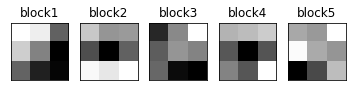

In [7]:
vgg16.summary()
layers = vgg16.layers
layer_ids = [1,4,7,11,15]
#plot the filters
fig,ax = plt.subplots(nrows=1,ncols=5)
for i in range(5):
    ax[i].imshow(layers[layer_ids[i]].get_weights()[0][:,:,:,0][:,:,0],cmap='gray')
    ax[i].set_title('block'+str(i+1))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

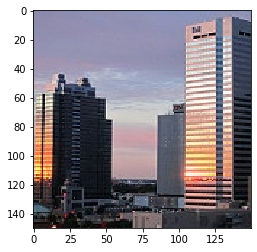

In [21]:
import cv2
#read the image
image = cv2.imread('5.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#resize image to appropriate dimensions
image = cv2.resize(image,(150,150))
plt.imshow(image)

In [22]:
from keras.applications.vgg16 import VGG16

# summarize filter shapes
for layer in vgg16.layers:
# check for convolutional layer
    if 'conv' not in layer.name:
        continue
# get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)


In [23]:
image = tf.keras.preprocessing.image.img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)

In [24]:
image = tf.keras.applications.resnet.preprocess_input(image)

In [25]:
vgg16 = Model(inputs=vgg16.inputs, outputs=vgg16.layers[1].output)

In [26]:
feature_maps = vgg16.predict(image)

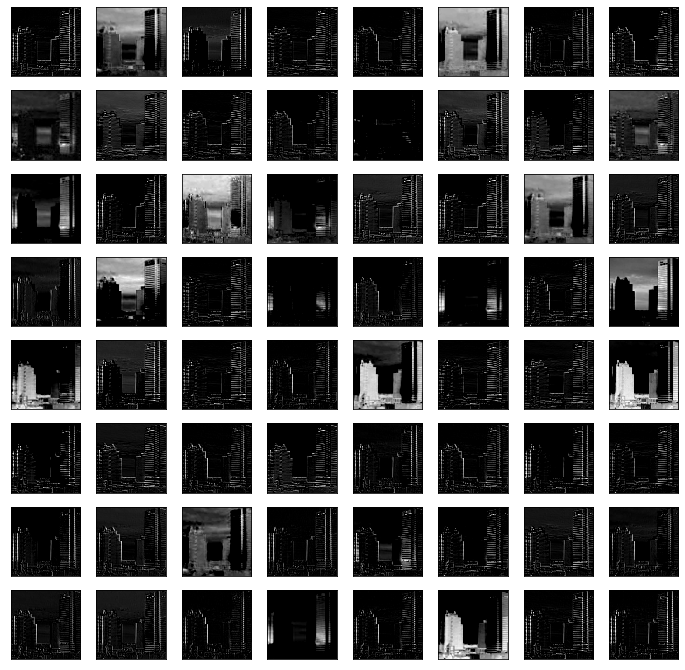

In [27]:
plt.figure(figsize=(12,12))
square = 8
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    plt.show()

In [28]:
vgg16 = VGG16(include_top = False,input_shape=(150,150,3),
                  weights='imagenet',
                  classes = 6)
ixs = [2, 5, 9, 13, 17]
outputs = [vgg16.layers[i+1].output for i in ixs]
vgg16 = Model(inputs=vgg16.inputs, outputs=outputs)
vgg16.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

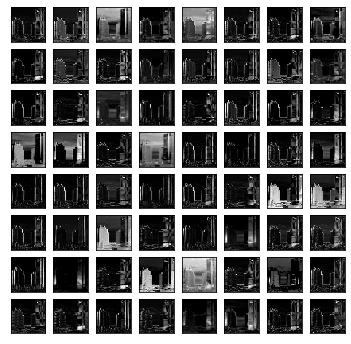

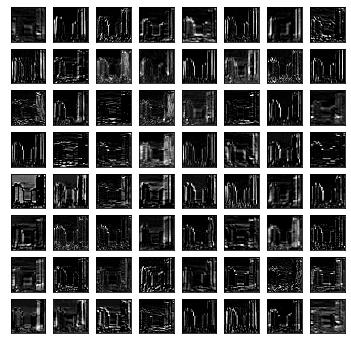

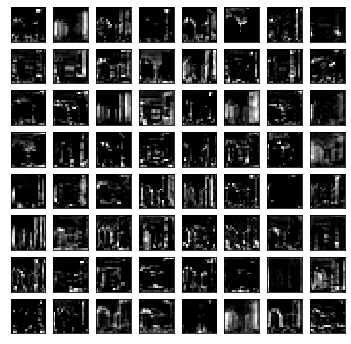

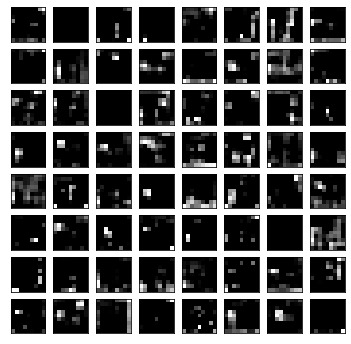

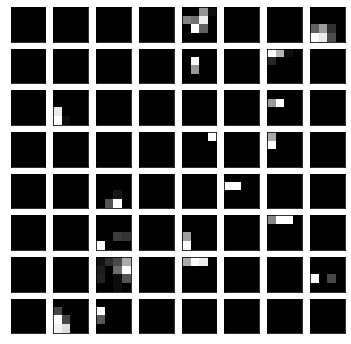

In [31]:
from keras import preprocessing
img = preprocessing.image.load_img('5.jpg', target_size=(150,150))
# convert the image to an array
img = preprocessing.image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = tf.keras.applications.resnet.preprocess_input(img)
# get feature map for first hidden layer
feature_maps = vgg16.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
    plt.figure(figsize = (6,6))
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()

In [62]:
modelvgg16.predict(img)

array([[1., 0., 0., 0., 0., 0.]], dtype=float32)